# Visual SLAM

<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S74_drone_perception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtsam
from gtbook.display import show
import gtsam.utils.plot as gtsam_plot

```{index} perception; visual SLAM
```

> When we do SLAM with cameras, we call it visual SLAM.

<img src="Figures7/S74-Autonomous_camera_drone-04.jpg" alt="Splash image with strange drone presumably thinking about maps" width="40%" align=center style="vertical-align:middle;margin:10px 0px">

Visual SLAM is *almost* the same problem as the "SLAM with Landmarks" problem from Section 6.4, but we will now use 3D poses and 3D points, and we will use the inertial measurements from the IMU to inform us about the movement of the platform. This is a typical pipeline on drones, phones, etc., everything with an IMU. 

Many unmanned aerial vehicles use cameras as their main sensors in addition to inertial sensing, as they are an incredibly rich sensing modality, do not consume a whole lot of energy, and are quite small. Especially the latter two considerations are very important in the weight and energy constrained world of autonomous drones. Furthermore, in military applications there is another reason to favor cameras over active sensors like LIDAR: cameras do not *emit* energy and hence are stealthier.

```{index} pair: structure from motion; SfM
```
Below we first introduce how we can estimate the trajectory of a drone using an inertial measurement unit or IMU, which we introduced in Section 7.2. Here we integrate IMU measurements over time to yield an estimate of the trajectory of the drone over time. Below that we discuss how we can build 3D maps from images alone (!), in a process called **structure from motion** or **SfM**. We then discuss Visual SLAM, which combines both IMU integration and SfM in a real-time, incremental pipeline. Implementing visual SLAM is beyond our scope, but it should be easy to imagine how inertial sensing and 3D reconstruction done together and in real-time is an incredible asset to autonomous flight.

## Integrating the IMU

We start off by encoding the information provided by the inertial measurement unit (IMU) in a factor graph.

As an example in code, below we define a scenario with forward velocity 2m/s, while pitching up
with angular velocity 30 degree/sec (negative in FLU). We set up a simulation using a built-in GTSAM class called the `ScenarioRunner`. To use this class, we need to define four things:

- a scenario: below we use a "constant twist" scenario, which is very much like the example in Section 7.2, a constant angular and linear velocity specified in the body frame
- noise parameters for the gyroscope and accelerometer
- the sample frequency, which we set at 10Hz
- bias parameters, to simulate how a bias actually corrupts the IMU measurements

We show how to create a `runner` with these parameters in Figure [1](#fig:scenario-runner).

In [3]:
#| caption: Creating a `ScenarioRunner` instance to simulate an IMU.
#| label: fig:scenario-runner
# Set up scenario with constant velocity model, both angular (W) and linear (V)
wb = np.array([0, -np.radians(30), 0])
vb = np.array([2, 0, 0])
scenario = gtsam.ConstantTwistScenario(wb, vb)

# Create noise parameters
noise_parameters = gtsam.PreintegrationParams.MakeSharedU(9.8)
kGyroSigma = np.radians(0.5) / 60  # 0.5 degree ARW
kAccelSigma = 0.1 / 60  # 10 cm VRW
I3 = np.identity(3, float)
noise_parameters.setGyroscopeCovariance(kGyroSigma**2 * I3)
noise_parameters.setAccelerometerCovariance(kAccelSigma**2 * I3)
noise_parameters.setIntegrationCovariance(0.0000001**2 * I3) # ignore this for now

# Set the sample time
dt = 0.1 # 10 Hz

# Create bias parameters
accBias = np.array([0, 0.1, 0]) # bias in accelerometer
gyroBias = np.array([0, 0, 0]) # bias in gyroscope
bias = gtsam.imuBias.ConstantBias(accBias, gyroBias)

# Instantiate IMU simulation class as `runner`
runner = gtsam.ScenarioRunner(scenario, noise_parameters, dt, bias)

Our approach will be to use the `runner` class to generate noisy measurements, and then use GTSAM to optimize for the optimal trajectory given those measurements.
With the `scenario` class, we can create some (good) initial values by calling the `scenario.navState` at $t=0$ as well as every 5 steps, which is twice per second, given our sampling time $dt=0.1$.
This is done in the code from Figure [2](#fig:init-values).

In [4]:
#| caption: Create initial values for visual SLAM, using the IMU simulation.
#| label: fig:init-values
# Define key naming scheme for GTSAM
X = gtsam.symbol_shorthand.X # for poses
V = gtsam.symbol_shorthand.V # for velocities
B0 = gtsam.symbol('b', 0) # for bias

# Create values and add initial state
values = gtsam.Values()
state = scenario.navState(0)
print(f"Adding initial state with position {np.round(state.pose().translation(),1)}")
values.insert(X(0), state.pose())
values.insert(V(0), state.velocity())

i, T = 0, 3.5 # run scenario at 10Hz for 3.5 seconds, adding state every 5th iteration
for j, t in enumerate(np.arange(0, T, dt)):
    if j>0 and j % 5 == 0:
        # create IMU factor
        i += 1
        state = scenario.navState(t)
        print(f"Adding navState {i} at t={t} with position {np.round(state.pose().translation(),1)}")
        values.insert(X(i), state.pose().retract(np.random.normal(scale=0.1, size=(6,))))
        values.insert(V(i), state.velocity() + np.random.normal(scale=0.1, size=(3,)))

# Add bias, as we will need it below
values.insert(B0, bias)

Adding initial state with position [0. 0. 0.]
Adding navState 1 at t=0.5 with position [1.  0.  0.1]
Adding navState 2 at t=1.0 with position [1.9 0.  0.5]
Adding navState 3 at t=1.5 with position [2.7 0.  1.1]
Adding navState 4 at t=2.0 with position [3.3 0.  1.9]
Adding navState 5 at t=2.5 with position [3.7 0.  2.8]
Adding navState 6 at t=3.0 with position [3.8 0.  3.8]


```{index} IMU preintegration
```
In Figure [3](#fig:imu-graph) we create the most complicated factor graph of the entire book, as it involves a factor that is connected to no less than five unknowns at every step. GTSAM contains a powerful, state of the art factor called the `ImuFactor` that allows us to accumulate IMU measurements and periodically add the resulting relative pose information to the graph. This process is called **IMU preintegration** and is used in many state-of-the-art navigation systems.

In code, this accumulation of (high-rate) IMU measurements is done in a class called `PreintegratedImuMeasurements`, abbreviated "PIM", which is done at 10Hz.
Every 5 steps we add an `ImuFactor` that is connected to two successive poses with keys `X(i)` and `X(i+1)` and their corresponding velocities with keys `V(i)` and `V(i+1)`, as well as the (single) bias unknown with key `B(0)`.

In [5]:
#| caption: Create a graph with IMU factors using the `ScenarioRunner` instance.
#| label: fig:imu-graph
# Create graph
imu_graph = gtsam.NonlinearFactorGraph()
Iso = gtsam.noiseModel.Isotropic
state = scenario.navState(0)
imu_graph.addPriorPose3(X(0), state.pose(), Iso.Sigma(6, 0.1))
imu_graph.addPriorVector(V(0), state.velocity(), Iso.Sigma(3, 0.1))
imu_graph.addPriorConstantBias(B0, bias, Iso.Sigma(6, 0.1))

i, T = 0, 3.5 # run scenario at 10Hz for 3.5 seconds, adding state every 5th iteration
pim = gtsam.PreintegratedImuMeasurements(noise_parameters, bias)
for j, t in enumerate(np.arange(0, T, dt)):
    measuredOmega = runner.measuredAngularVelocity(t)
    measuredAcc = runner.measuredSpecificForce(t)
    pim.integrateMeasurement(measuredAcc, measuredOmega, dt)
    if j>0 and j % 5 == 0:
        # create IMU factor
        factor = gtsam.ImuFactor(X(i), V(i), X(i + 1), V(i + 1), B0, pim)
        imu_graph.push_back(factor)
        i += 1
        pim.resetIntegration()

In Figure [4](#fig:imu_graph) we display the resulting factor graph. The figure shows (a bit messily) that the IMUFactors tie together the `Pose3` states $x_k$, the velocities $v_k$ and the unknown IMU biases $b_0$.

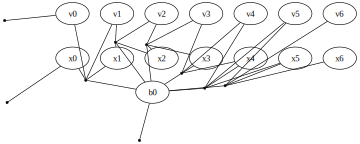

In [6]:
#| caption: A (somewhat messy) factor graph for the IMU preintegration problem.
#| label: fig:imu_graph
position_hints = {'u': 2, 'x': 1, 'z': 0}
position_hints.update({'v':2})
show(imu_graph, gtsam.Values(), hints=position_hints)

We can optimize even *without* any external measurements, but unless you pay for a very expensive IMU, your estimate will drift very rapidly. The result of this IMU-only optimization is shown in Figure [5](#fig:imu_result).

In [7]:
print(f"initial error: {imu_graph.error(values)}")
lm = gtsam.LevenbergMarquardtOptimizer(imu_graph, values)
imu_result = lm.optimize()
print(f"final error: {imu_graph.error(imu_result)}")

initial error: 22971318.12067142
final error: 3.169445405134413e-23


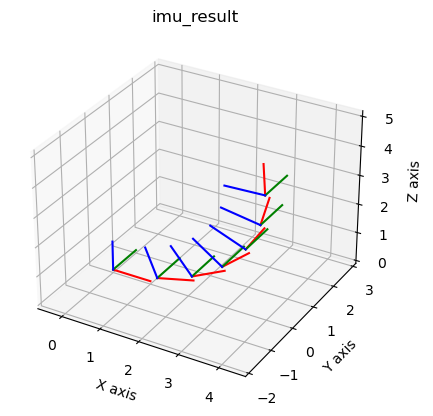

In [8]:
#| caption: Result of the IMU preintegration optimization.
#| label: fig:imu_result
i = 0
while imu_result.exists(X(i)):
    gtsam_plot.plot_pose3(1, imu_result.atPose3(X(i)), 1)
    i += 1
plt.title("imu_result")
gtsam.utils.plot.set_axes_equal(1)

## Incorporating Visual Measurements

> Structure from Motion is 3D reconstruction from images.

In this section we provide an introduction to reconstructing a 3D environment from camera images over time, which allows for planning and obstacle avoidance, which we discuss in more detail in the next section. However, mapping the environment is, in and of itself, a useful capability in many applications. In some industrial and military applications, the map *is* the product of interest. In this section we discuss 3D reconstruction as a *batch* process, done after the drone has collected images.

<figure id="fig:Balbianello">
<img src="https://github.com/gtbook/robotics/blob/main/Figures7/Balbianello.jpg?raw=1" alt="Balbianello">
<figcaption>Five images of the "Balbianello" villa on lake Como, taken from a moving boat. </figcaption>
</figure>

Structure from Motion, or SfM, is the problem of computing the 3D structure of a scene from multiple images, either taken from different cameras, or taken at different times as the camera moves in the environment. In Figure [6](#fig:Balbianello) we show one such image sequence, five images of the "Balbianello" villa in Italy, situated on lake Como.

```{index} bundle adjustment
```
SfM is almost the same problem as Visual SLAM, but typically there is no odometry information to relate
different camera views. The resulting optimization problem is sometimes called **bundle adjustment**. 
The most difficult problems associated with SfM are feature detection, data association, and initializing the optimization.

Below we load the Balbianello data from a file and create a factor graph, as well as an initial estimate. A lot of work is done in the code snippet below! The particular file format, which stems from the "Bundler" library, is transformed into a data structure `sfm_data`. The method `sfmFactorGraph` then creates a factor graph with *all* the projection factors derived from the close to 1500 visual measurements. The `initialCamerasAndPointsEstimate` method next instantiates a `Values` object with initial estimates for all the cameras and the points, extracted from the Bundler file. We then print the initial error and see that it has a value of $126.9$, which is normalized with respect to 1-pixel standard deviation given in the noise model.

In [9]:
filename = gtsam.findExampleDataFile("Balbianello.out")
sfm_data = gtsam.SfmData.FromBundlerFile(filename)
model = gtsam.noiseModel.Isotropic.Sigma(2, 1.0)  # one pixel in u and v
graph = sfm_data.sfmFactorGraph(model)
initial = gtsam.initialCamerasAndPointsEstimate(sfm_data)
print(f"initial error: {graph.error(initial):.1f}")

initial error: 126.9


The code above already did most of the heavy lifting that was so cumbersome and manual in earlier sections of this book, but it does not yet optimize! We once again use the Levenberg-Marquardt non-linear optimizer below, which is now performing *structure from motion*: we optimize for both the unknown camera poses (intrinsic camera calibration is assumed known here) and the unknown 3D points in the scene:

In [10]:
lm = gtsam.LevenbergMarquardtOptimizer(graph, initial)
result = lm.optimize()
print(f"final error: {graph.error(result):.1f}")

final error: 125.5


The final error is not much smaller than the initial error, which tells us that the initial estimate was already very good. It is quite fortunate to have found that initial estimate in the file, because in many cases initializing a structure from motion problem can be quite a difficult undertaking. When we are flying a drone, we can build up an estimate of the 3D environment gradually, and hence an initial estimate is always available to use from the previous time step. However, we will not discuss this more in depth here.

The result of SfM is a sparse point cloud and a set of well-determined camera poses, which can be "densified" using multi-view stereo techniques. This is out of scope of this book, however, and below we simply extract the 3D points and display them in 3D with `plotly`, in Figure [7](#fig:sfm_result).

In [11]:
structure = gtsam.utilities.extractPoint3(result)
valid = structure[:,2] > -5.0
bRc = sfm_data.camera(0).pose().rotation()
wRc = gtsam.Rot3([1,0,0],[0,0,-1],[0,1,0]) # make camera point to world y
wRb = wRc.compose(bRc.inverse())
structure = (wRb.matrix() @ structure.T).T

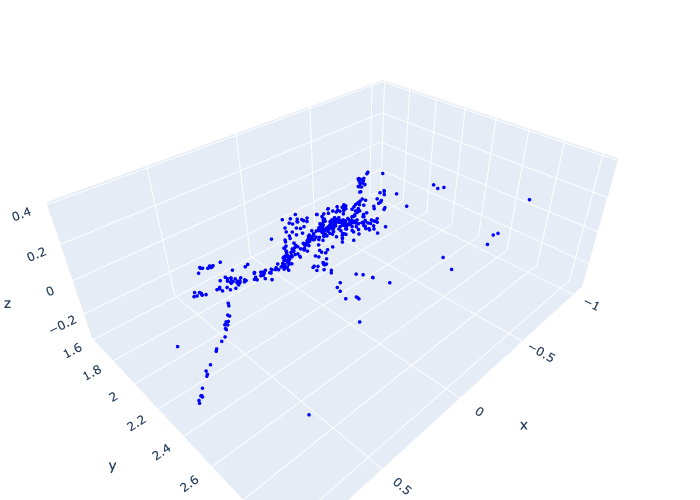

In [12]:
#| caption: Structure from motion result as a sparse 3D point cloud.
#| label: fig:sfm_result
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=structure[valid,0],y=structure[valid,1],z=structure[valid,2],
    mode="markers", marker=dict(size=2, color="blue"), showlegend= False))
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
fig.update_yaxes(scaleanchor = "x", scaleratio = 1); fig.show()

## Visual SLAM

> Visual SLAM is based on Structure from Motion.

Visual SLAM combines both IMU integration and SfM in a real-time, incremental pipeline. Typically, The drone starts with no pre-built map, opens its eyes as it were, and starts building a 3D map of the environment incrementally. Initial estimates for the camera positions are given by integrating the IMU forward. New landmarks are added incrementally as the drone progresses throughout the environment. Fast, incremental optimization techniques can be used to keep the computation under control, but discussing these is out of scope for an introductory textbook. Suffice to say that, modulo a *lot* of engineering efforts, this process can be made to work incredibly well. When done well, this provides a superpower to autonomous drones, allowing them to map their environment in real time and enabling obstacle avoidance and planning in hitherto unknown environments.

Visual SLAM from images and IMU integration compliment each other perfectly. The IMU excels at dealing with high frequency motion like vibrations, which is common on drones. However, it suffers from drift: the inertial measurement units available for consumer drones can drift away from the true trajectory quite rapidly. High quality IMUs are typically very expensive and only available in high-end applications. In fact, this technology is so sensitive that even *disclosing* the accuracy of military-grade IMUs is a crime in many countries. Visual SLAM, on the other hand, is not great at dealing with high frequency motions, but does not suffer from drift as much, especially in environments where many loop closures can be made. It is only in very long, open-ended trajectories that drift again becomes a problem.

## Summary



Above we introduced Visual SLAM as an extension of SLAM with landmarks and its critical integration with an IMU integration process. We discussed how the latter can be done with factor graphs, and while these are some of the most complex factor graphs we have encountered, the principle stays the same. Structure from motion was introduced as a method for constructing 3D maps from images, and while we did not go into too much detail about the specific factors, the same optimization pattern can be found at its center. Visual SLAM was then introduced, at a high level, as a combination of IMU integration and SfM.